# Problem Set 1 (20 + 40 + 30 = 90 points)

## Important information
1.  We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

2.  Please submit the single Jupyter Notebook file, where only Python and Markdown/$\LaTeX$ are used. Any hand-written solutions inserted by photos or in any other way **are prohibitive and will not be graded**. If you will have any questions about using Markdown, ask them!
3.  The works will be checked for **plagiarism**. The score will be divided by the number of similar works.

4. Some tasks in this assignment are bonus. It means that you can get maximum score for this assignment even if you ignore these tasks. However, if you get $y$ points for bonus tasks and $x$ points for regular tasks, then your score for the assignment will be $\min(90, x+y)$. If $x + y > 90$, then we will label your submission and take into account in the final grade releasing (e.g. in the border case).

## Problem 2. Voice classification (40 pts)

In this assigment you will have a chance to develop a voice-anti-spoofing algorithm, enhancing your skills in standard PyTorch classificaton development pipeline.

There are several types of attack: 
- replay attacks, when one records and repeats someone's voice, 
- impresario attacks, when the speaker mimics the target's voice like an actor and 
- the most interesting are deepfake attack, based on text-to-speech, voice cloning and voice conversion algorithms. 

In this work we will focus on deepfake attack and try to differ them from genuine (or bona-fide) speech.

We will use data, provided by organisers of biannual [ASVspoof](https://www.asvspoof.org/) contest. More precisely, we will take subpart `ASVspoof_2019LA` dataset, which consist of 17 different attacks DF attack types and bona-fide. All recordings were augmented to be close to real telephone recordings. We will not take 2021 data, but if you want, you can use 2021 data as test and 2019 data as train and validation.

The initital dataset can be downloaded from [here](https://datashare.ed.ac.uk/handle/10283/3336). However, we [provide you smaller subsample](https://drive.google.com/drive/folders/1-CyCFA3komqrtyoYj21y5gzfh_vcKBYx?usp=share_link) of dev (val) and eval (test) parts to make work in colab relatively possible :) . You can download it locally or put into you Drive. You will need around 3GB free space, think about creating a new account if you don't have enough.

We encourage you to look through data [overview](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_evaluation_plan.pdf?sequence=1&isAllowed=y) and result summary [paper](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_Interspeech2019_submission.pdf?sequence=2&isAllowed=y).

One important thing to notice: main application of this algorithms is in voice-biometry, when we want to stop illegal intruder. Thus, there are two (or 3) common ways of developing VAS algorithms: speaker-aware, we we train verification model which is sensitive to spoofing and differs bona-fide and impostor or we combinde verification score and score of VAS model to decide, whetherr the person is the same, and finally simple and general countermeasures setup, when given audio and model should predict whether it is a spoof or bona-fide. We will work on the last setup.

**Important: feel free not to use pre-defined functions, you can solve the task as you wish or change functions/pipelines significantly.** 

#### Preparations
It is a good practice to log and check you experiments. In this assignemnt, we ask you to sign up in wandb, log your experiments and give us a link to your project and attach plots/report in the notebook with your solution.

In [18]:
!pip install wandb

import copy
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from typing import Optional
import torch
import torchaudio
import torch.nn as nn
import librosa
import sklearn.metrics as metrics
import wandb
from torchvision.models import resnet50, resnet18
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# https://wandb.ai/quickstart

!wandb login  # and paste your API key from https://wandb.ai/authorize

wandb: Currently logged in as: anna1357910. Use `wandb login --relogin` to force relogin


In [20]:
wandb.init(project="voice-anti-spoofing", name = "test_run", tags = ["SmallModel", "LA"])
SEED = 42  # do not change it
# mount drive if you wish

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


In [21]:
!ls for_colab

ASVspoof2019_LA_cm_protocols  df_train.csv  old		   train_flac.zip
df_dev.csv		      flac_dev	    README.LA.txt
df_eval.csv		      flac_eval     train_flac


In [22]:
# to make dataframes
path_la_train = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
path_la_dev = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
path_la_eval = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

flac_la_train = "for_collab/train_flac/"
flac_la_dev = "for_collab/flac_dev/"
flac_la_eval = "for_collab/flac_eval/"

In [5]:
columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
df = pd.read_csv(path_la_train, sep=" ", header=None)
df.columns = columns
df.head()

,speaker_id,audio_file_name,system_id,skip,class
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [23]:
def makedf_ultimate(txt_file_path, flac_path, dataset_name='ASVspoof', data_type='LA', year=2019):
    
    if dataset_name=='ASVspoof':
        name = dataset_name+str(year)+data_type
        if data_type=='DF':
            attack_name = 'deepfake'
        elif data_type=='LA':
            attack_name = 'deepfake'
        else:
            attack_name = 'replay'
            
        df = pd.read_csv(txt_file_path, sep=" ", header=None)

            
        if year == 2019:
            df.columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
            df['dataset'] = name
            di = {'bonafide':0, 'spoof':1} # assign classes

            df['class'] = df['class'].map(di)
            # m = df['class'] == 0
            # df.loc[m, 'attack'] = 'noattack'
            df['audio_path'] = flac_path + df['audio_file_name'] + '.flac'
            df = df[["speaker_id", "audio_path", "class"]]
        
    # df = df[['audio_path', 'class', 'dataset', 'attack']]
    df = df[["speaker_id", "audio_path", "class"]]
    df = df.reset_index(drop=True)
    return df

In [24]:
df_train = makedf_ultimate(path_la_train, flac_la_train, year=2019, data_type='LA')
df_dev = makedf_ultimate(path_la_dev, flac_la_dev, year=2019, data_type='LA')
df_eval = makedf_ultimate(path_la_eval, flac_la_eval, year=2019, data_type='LA')

In [ ]:
df_train.head()

,speaker_id,audio_path,class
0,LA_0079,for_collab/train_flac/LA_T_1138215.flac,0
1,LA_0079,for_collab/train_flac/LA_T_1271820.flac,0
2,LA_0079,for_collab/train_flac/LA_T_1272637.flac,0
3,LA_0079,for_collab/train_flac/LA_T_1276960.flac,0
4,LA_0079,for_collab/train_flac/LA_T_1341447.flac,0


**Task 1.1 (2 points)** Check data distribution. Is it imbalanced? How are you going to deal with it?

Hints: upsampling, downsampling, add new data, e.g. from this [source](https://commonvoice.mozilla.org/) (but will new audios have the same distribution?), or adjust loss functions.

**Answer**

The data is unbalanced, the number of "bonafide" classes records is 10 times less.I think weighted sampling and a cross-entropy loss function are the best strategy for completing this task. As a result, we will be able to include more instances of the minor class and give them more attention when evaluating the model.

1    22800
0     2580
Name: class, dtype: int64


<Axes: ylabel='Type'>

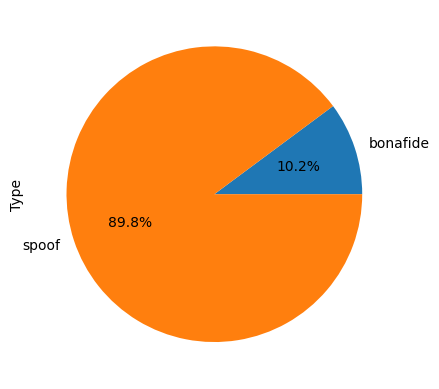

In [ ]:
print(df_train["class"].value_counts())

df.groupby('class').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [25]:
# for dev and eval, let's simplify the task and use smaller amount of data, but balanced to better understand metrics
# we need this functions, because it removes unuploaded data from our dataframes
def balanced_split(df):
    k = min(len(df[df['class']==0]), len(df[df['class']==1]))
    print(k)
    df_bf = df[df['class']==0].sample(frac=1, random_state=SEED).iloc[0:k]
    df_spoof = df[df['class']==1].sample(frac=1, random_state=SEED).iloc[0:k]

    df_bf = df_bf.append([df_spoof], ignore_index=True)
    df_bf = df_bf.reset_index(drop=True)
    return df_bf

df_eval = balanced_split(df_eval)
df_dev = balanced_split(df_dev)

7355
2548


<ipython-input-25-295d12be0fb0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bf = df_bf.append([df_spoof], ignore_index=True)


In [ ]:
print(df_eval["class"].value_counts())


0    7355
1    7355
Name: class, dtype: int64


In [ ]:
print(df_dev["class"].value_counts())

0    2548
1    2548
Name: class, dtype: int64


In [ ]:
# for audio manipulations we advise you to use torchaudio or librosa
x, sr = torchaudio.load(df_eval["audio_path"].iloc[0])

In [ ]:
ipd.display(ipd.Audio(x, rate=sr))

**Task 1.2. (1 point)** Display several spoof and bona-fide audios. Can you hear the difference?

In [9]:
print("Class 0 from df_eval")
x, sr = torchaudio.load(df_eval[df_eval["class"] == 0]["audio_path"].iloc[1])
ipd.display(ipd.Audio(x, rate=sr))
print("Class 1 from df_eval")
x, sr = torchaudio.load(df_eval[df_eval["class"] == 1]["audio_path"].iloc[1])
ipd.display(ipd.Audio(x, rate=sr))

Class 0 from df_eval


Class 1 from df_eval


Yes! There is a difference, the voice is very synthetic.

### Custom dataset and Model

You can find inspiration and hints in 
- https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://pypi.org/project/audiomentations/ 
- https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html
- and any other blogposts about spectrograms

**Task 2.1 (5 points)** We can work with audios as with images, transforming into spectrograms. Here your task is to implement simple model, which receives raw wav (amplitudes, but probably already preprocced in dataset), transforms it into mel-spectrogram, changes amplitude to DB scale (if you want) and then procceses through the layers. You are free to use ready pre-trained backbones, e.g. from `torchvision.models` and fine-tune them. However, if you want to practise more, create something on your own. Large models with `requires_grad=True` for all parameters will probably result in problems on training in colab. 

In [36]:
import torch.nn.functional as F
import torchvision.models 

class WavResNet(nn.Module):
    def __init__(self, classes=None, resample=16000, n_mels=80, melspec_config=None):
        super().__init__()
        
        self.fbank = torchaudio.transforms.MelSpectrogram(sample_rate=resample, n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=n_mels)
        
        model = torchvision.models.resnet34(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, classes)
        self.network = model
        # or create your own layers and use them in forward pass
        
    
    def forward(self, x, wav_lens: Optional[torch.Tensor]=None):  # can check the length if you want. this is helpful for inference
        mels = self.fbank(x)
        mels_db = self.to_db(mels)
        out = self.network(mels_db)
        out = F.softmax(out, dim=1)
        return out

**Task 2.2 (1 point)**
In your opinion, which approach is better for binary classification: 
- Model's last layer output has shape 1, train with BCE-like loss.
- Model's last layer output has shape 2, train with cross-entropy like loss. 

**Answer:** Cross-entropy, in my opinion, is a better choice for our model.  The drawbacks of this approach include the higher number of instances needed and the high cost of computation, but we will be able to train the model more precisely in the case of unbalanced classes.


**Task 2.3 (3 points)** Create custom dataset, which recieves ```df``` and returns preprocessed audio.

**Task 2.4 (1 point)** Should we use augmentaions? If yes, which ones? 

**Answer:** Since our dataset is unbalanced, it is important to apply augmentation to generate new examples for free and make training dataset bigger.
Random clipping, Speed perturbation, Background noise, Combine transformations

In [37]:
class DatasetWav(Dataset):

    def __init__(self, data_frame, padding_sec=4, default_sr=16000, transform=None):
        self.df = data_frame
        self.padding_sec = padding_sec
        self.default_sr = default_sr
        self.labels = list(self.df['class'])
        self.paths = list(self.df['audio_path'])

        self.vad = torchaudio.transforms.Vad(sample_rate=self.default_sr, trigger_level=7.0)  # remove silences at the beggining/end
         # in this task you are free to ommit it in order to speed up calculations,
                         # also the provided data should be rather clean
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):

        label = self.labels[idx]
        path = self.paths[idx]
        waveform , sr = torchaudio.load(path, normalize=True) # normalize=True
        if waveform.shape[0] > 1:
          waveform = torch.mean(waveform, dim=0, keepdim=True)
          
        resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.default_sr)
        # should we use it for our data or can ommit? 
        # Answer: should be left as it converts the frequency
        waveform = resample_transform(waveform)
        #waveform = self.vad(waveform)


        # came up with idea, what to do if audio is longer or shorter than reuqired
        if (len(waveform) < self.padding_sec * self.default_sr):
          n_rep = int(np.ceil(self.padding_sec * self.default_sr / waveform.shape[1]))
          waveform = waveform.repeat(1, n_rep)
          waveform = waveform[:, :self.padding_sec * self.default_sr]
        else:
          waveform = waveform[:, :self.padding_sec * self.default_sr]



        return waveform, label

In [38]:
# check that works
%%time
batch_size = 64
train_dataset_wavs = DatasetWav(df_train) #.iloc[0:200]
train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
x, y = next(iter(train_dataloader_wavs))
model = WavResNet(classes=2)
model(x)

CPU times: user 16.6 s, sys: 3.6 s, total: 20.2 s
Wall time: 24.6 s


tensor([[0.6825, 0.3175],
        [0.7788, 0.2212],
        [0.5510, 0.4490],
        [0.6672, 0.3328],
        [0.7337, 0.2663],
        [0.6274, 0.3726],
        [0.6630, 0.3370],
        [0.5301, 0.4699],
        [0.6360, 0.3640],
        [0.5905, 0.4095],
        [0.7007, 0.2993],
        [0.5693, 0.4307],
        [0.6436, 0.3564],
        [0.5986, 0.4014],
        [0.5385, 0.4615],
        [0.6787, 0.3213],
        [0.4339, 0.5661],
        [0.5216, 0.4784],
        [0.6747, 0.3253],
        [0.6578, 0.3422],
        [0.5724, 0.4276],
        [0.4707, 0.5293],
        [0.7473, 0.2527],
        [0.5791, 0.4209],
        [0.6866, 0.3134],
        [0.5856, 0.4144],
        [0.4305, 0.5695],
        [0.5908, 0.4092],
        [0.6448, 0.3552],
        [0.6861, 0.3139],
        [0.7420, 0.2580],
        [0.5808, 0.4192],
        [0.5689, 0.4311],
        [0.6332, 0.3668],
        [0.5632, 0.4368],
        [0.5497, 0.4503],
        [0.7065, 0.2935],
        [0.4656, 0.5344],
        [0.6

### Train and Test functions
**Task 3.0 (1 point)** What is the difference between `model.train()` and `model.eval()`? Does `model.eval()` mode take gradient statisitcs into account?

**Answer**

In `model.train()` we count gradients, update params and use dropou. In `model.eval()` we implement finetuning: forbid the model to make a back propagation and perform training actions, that need to evaluate the model's performance

**Task 3.1 (5 points)** Implement train and test functions, which iterate over all batches. Do logging of loss, accuracy on each batch and after every epoch. Check equal error rate EER, explain, what is it.

**Answer**
EER is used to confirm the identity of the person on record. We can determine the point where these values are equal using FAR (probability of accepting a false person) and FRR (probability of rejecting a true person), which will be EER.

In [29]:
def calculate_eer(y, y_score):
  fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
  eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
  thresh = interp1d(fpr, thresholds)(eer)
  return eer, thresh

In [41]:
def train(model, dataloaders, criterion, optimizer,num_epochs=3, scheduler=None, savename=None,
          print_counter=10, decay_factor=10,
          device=torch.device("cuda")):

    train_loader = dataloaders['train']
    val_loader = dataloaders['val']
    val_acc_arr = []
    print("TRAIN")
    for epoch in range(num_epochs):
      
      model.train() 
      avg_loss, avg_acc = 0, 0
       
      for batch, (x, labels) in tqdm(enumerate(train_loader)):
          
          x, labels = x.to(device), labels.to(device)
          optimizer.zero_grad()
        
          # Compute prediction error
          y = model(x)
          _, preds = torch.max(y, 1)
          loss = criterion(y, labels)
          # Backpropagation
          loss.backward()
          optimizer.step()

          avg_loss += loss.item()
          avg_acc += torch.sum(preds == labels) / len(labels)
          
      train_loss = avg_loss / len(train_loader)
      train_acc = avg_acc / len(train_loader)

      # if scheduler:
      #   scheduler.step()

      model.eval()
      val_loss = 0
      val_acc = 0

      with torch.no_grad():
        for ind, (x, labels) in enumerate(val_loader):
          x, labels = x.to(device), labels.to(device)
          y = model(x)
          loss = criterion(torch.log(y / (1 - y)), labels)
          _, preds = torch.max(y, 1)
          val_loss += loss.item() 
          val_acc += torch.sum(preds == labels) / len(labels)
      
      val_loss /= len(val_loader)
      val_acc /= len(val_loader)

      print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.3f}; val loss {val_loss:.4f}; val acc {val_acc:.4f}')
      
      if savename:
        torch.save(model.state_dict(), savename + f'_{epoch}')
    return model, val_acc

def test(model, test_dataloader, criterion=None, device=torch.device("cuda"), savename=None):
    
    model.to(device)
    model.eval()
    test_loss, test_acc = 0, 0
    test_labels = []
    test_preds = []
    with torch.no_grad():
      print("TEST")
      for batch,(X, labels) in tqdm(enumerate(test_dataloader)):
        X, labels = X.to(device), labels.to(device)
        y = model(X)
        _, preds = torch.max(y, 1)
        test_loss += criterion(y, labels)
        test_acc += torch.sum(preds == labels) / len(labels)
        test_labels.extend(labels.cpu().numpy().tolist())
        test_preds.extend(y.cpu().numpy().tolist())

    test_acc = test_acc / len(test_dataloader)
    test_loss /= len(test_dataloader)  
    print(f'test loss: {test_loss:.3f}; test acc: {test_acc:.3f}')
    if savename:
      torch.save(model.state_dict(), savename)

    return test_labels, test_preds
    

### Main loop 

**Task 4.1 (3 points)** What loss will you choose and why? What it should receive for input (logits, probs)? Explain your answer.
Consider also:
- https://medium.com/swlh/focal-loss-what-why-and-how-df6735f26616
- https://libauc.org/


**Task 4.2 (5 points)** Implement main function, which receives yaml or json config (or path to it) and train and test the model, save model checkpoints, and model's test predictions. At least, you should obain results better than random. It is good, if accuracy on test dataset is >= 0.75.

In [42]:
def main(config):
    lr = config['lr']
    epochs = config['epochs']
    batch_size = config['batch_size']
    wandb.init(project="voice-anti-spoofing", name = "test_run", tags = ["ResNet", "LA"])
    wandb.config = {
      "learning_rate": lr,
      "epochs": epochs,
      "batch_size": batch_size
    }

    
    # debug firstly on small subpart of dataset

    df_train = config['df_train'].sample(frac=1, replace=False).reset_index(drop=True)
    df_eval = config['df_eval'].sample(frac=1, replace=False).reset_index(drop=True)
    df_dev = config['df_dev'].sample(frac=1, replace=False).reset_index(drop=True)

    train_dataset_wavs = DatasetWav(df_train) 
    train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
    val_dataset_wavs = DatasetWav(df_dev)
    val_dataloader_wavs = DataLoader(val_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
    test_dataset_wavs = DatasetWav(df_eval)
    test_dataloader_wavs = DataLoader(test_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
    dataloaders = {"train": train_dataloader_wavs, "val": val_dataloader_wavs}
    
    
    device = 'cuda'
    classes = 2                                         
    model = WavResNet(classes=classes)                                                                            
    model = model.to(device)
    # freeze layers except the last one if you want
    for param in model.parameters():
      param.requires_grad = False
    model.network.fc.requires_grad_(True)
                                                                                           
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = None
    alpha = df_train[df_train['class']==1].shape[0] /df_train.shape[0]
    sc = torch.tensor([alpha, 1 - alpha]).to(device) # weights for loss
    criterion = nn.CrossEntropyLoss(weight=sc)
    
    for_ckpts = "."
    os.makedirs(for_ckpts, exist_ok=True)

    savename = for_ckpts + '/weights_final_model'

    model, val_acc_history = train(model, dataloaders, criterion, optimizer, epochs, scheduler, savename)
    
    test_labels, test_preds = test(model, test_dataloader_wavs, criterion, savename=savename)
    
    return test_labels, test_preds

config = {
    'epochs':1,
    'lr':0.0002,
    'batch_size':64,
    'df_train':df_train,
    'df_eval':df_eval,
    'df_dev':df_dev
}

test_labels, test_preds = main(config)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also u

TRAIN


397it [01:42,  3.87it/s]


[Epoch 1] train loss: 0.638; train acc: 0.701; val loss 0.5167; val acc 0.7495
TEST


230it [00:57,  3.98it/s]


test loss: 0.595; test acc: 0.767


Training might require a long time. So, you can try to use subpart of the dataset to receive rather good results. Also, you don't have to train for many epochs, 1 or even a half of epoch might be enough. Also consider to make some speedups in the model and dataset.

Colab also might work unstable with lots of data. If this happens, think how to deal with it, e.g. restart the kernel and/or remove the majority of data from Drive and try to bugfix firstly, then do train and test separately. 



**Task 4.3 (5 points)** Analyze the results. Play some audios with wrong predictions. Plot prediction distributions vs class. Is it possible to find better threshold?

**Task 4.4 (5 points)** Discuss the results and your approaches + hyperparameters. If you can, run some experiments with different parameters.

 Write your ideas, what else you can try to improve the results in the future.

**Task 4.5 (3 points)** Provide link to wandb project, or link to report. Upload best model's weights to Drive and provide a link with access right.

**Answer:**https://wandb.ai/anna1357910/voice-anti-spoofing/runs/s1lbbjv8?workspace=user-anna1357910

In [33]:
errors = df_eval.iloc[np.where(np.array(test_preds) != np.array(test_labels))[0]]

print('False positive:')
for i in range(3):
  audio_path = errors[errors["class"] == 0]["audio_path"].iloc[i]
  x, sr = torchaudio.load(audio_path)
  ipd.display(ipd.Audio(x, rate=sr))

print('False negative:')
for i in range(3):
  audio_path = errors[errors["class"] == 1]["audio_path"].iloc[i]
  # waveform, sample_rate = torchaudio.load(audio_path)
  x, sr = torchaudio.load(audio_path)
  ipd.display(ipd.Audio(x, rate=sr))

False positive:


False negative:


**Bonus task. (50 points)** 

So far, we didn't care about speaker_id and verification. Take verification model from whatever you want and create counter measure subnetwork, as described in this [article](https://sasv-challenge.github.io/pdfs/2022_descriptions/IDVoice.pdf). Train the model, as described there. ASVspoof also provides Enrollment(anchor) recordings. Try to make blending, to obtain better metrics for counter measures.

These links might be helpful:
- https://github.com/archinetai/surgeon-pytorch
- https://www.kaggle.com/code/peter0749/additive-margin-softmax-loss-with-visualization

## Problem 3. (30 pts)

### Task 1 (10 pts)

For FCNN (Fully connected Neural Networks)
\begin{equation}
f(x)=f_k\left(f_{k-1}\left(\ldots\left(f_0(x)\right)\right),\right.
\end{equation}
assume the nonlinearity function $\sigma$ is ReLU and loss function $L$ is squared error loss function.
Prove that the deep learning model is not unique for any datasets, i.e. the optimization problem 
\begin{equation}
\min_\theta \ g(\theta)=\frac{1}{N} \sum_{i=1}^N L\left(y_i, \hat{y}_i\right), \text{where} \ \ \hat{y}_i=f\left(x_i, \theta\right),
\end{equation} 
dose not have an unique global minimizer $\theta$.

### Task 2 (5 pts)

The *softmax* activation function is 
\begin{equation}
\mathrm{Softmax}(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \ \text { for } \  i=1, \ldots, K \text { and } \mathbf{z}=\left(z_1, \ldots, z_K\right) \in \mathbb{R}^K.
\end{equation}
Suppose $\mathbf{z} \in \mathbb{R}^K$, and $\mathbf{a} \in \mathbb{R}^K$,
Prove that for the optimization problem
\begin{equation}
\begin{aligned}
& \min_{\mathbf{a}} \ -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle \\
& \text { s.t. } \sum_k^K \mathbf{a}_{k}=1,
\end{aligned}
\end{equation}
the minimizer is 
\begin{equation}
\mathbf{a}^*=\mathrm{Softmax}(\mathbf{z}).
\end{equation}

*Hint*: KKT optimality conditions and convexiy of the problem can help you to show the required equality

### Task 3 (15 pts)

For function $f(x)=x^2, x \in \left[0, 1\right]$, 

1) prove that the neural network $\hat f(x)$ based on the following structure has the approximation error 
\begin{equation}
|f(x)-\hat f(x)|\leq \frac{1}{2^{n-1}}
\end{equation}
where $n$ is the number of layers in the neural network.

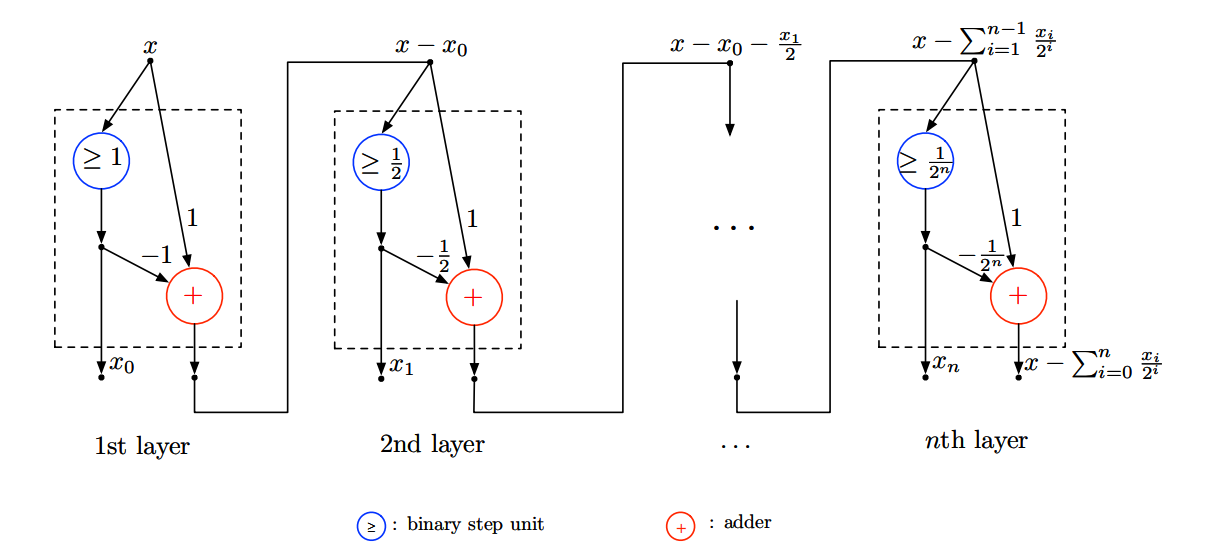

*Hint*: For each $ x \in \left[0, 1\right]$, $x$ can be denoted by its binary expansion $x=\sum_{i=0}^{∞} x_i/2^i$, where $x_i \in \{ 0, 1\}$. The above structure can be used to find $x_0,\dots, x_n$. Then we can write $\hat f(x)=f\left(\sum_{i=0}^{∞} x_i/2^i\right).$

After the proof, if we want to achieve $\epsilon$ appoximation error based on the above neural network, the number of layers $n$ has to satisfy the condition $\frac{1}{2^{n-1}}\leq \epsilon$, i.e. $n\geq \log_2 \frac{1}{\epsilon}$.

2) Implement this neural network in any framework you like with different $n$ (for example $n = 3, 5, 10, 15$), and then plot the curve for absolute errors for different $n$. Compare the obtained plots with theoretical bound.


**Task 1**

The issue is reduced to solving the optimization problem $||\hat{y}-y||_2^2 \rightarrow min_a$ because the fully connected layers, that stand between the activation layers, can be combined by multiplying by a single matrix. The optimization problem cannot be solved with a singular solution when there are more instances than features. Any element from the integer vector space may be added to any minimization problem solution to produce additional solutions to the same issue. We can also infer that since the activation layer won't alter this characteristic, the solution to the optimization problem for the entire network will also not be unique.

**Task 3**

For each $ x \in \left[0, 1\right]$, $x$ can be denoted by its binary expansion $x=\sum_{i=0}^{∞} x_i/2^i$, where $x_i \in \{ 0, 1\}$. Then we can write $x=\sum_{i=0}^{∞} x_i/2^i$, $ \hat{x} = \sum_{i=0}^{n} x_i/2^i$

So $|x - \hat{x}|=|\sum_{i=0}^{∞} x_i/2^i - \sum_{i=0}^{n} x_i/2^i| = |\sum_{i=n+1}^{∞} x_i/2^i|$

was needed to prove, what $|\sum_{i=n+1}^{∞} x_i/2^i| <= \frac{1}{2^n}$

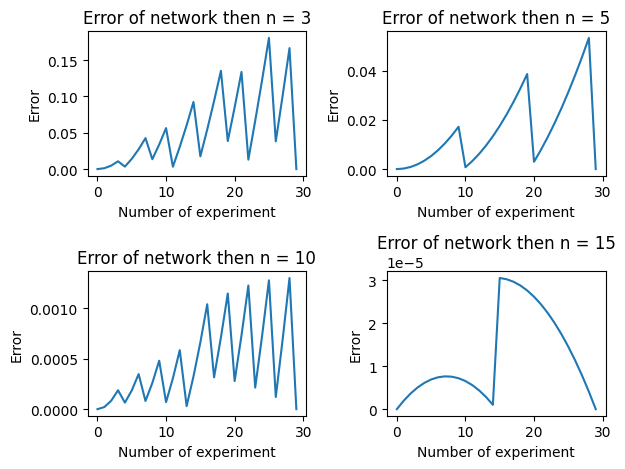

  n    max_absolute_error    theoretical bound
---  --------------------  -------------------
  3           0.180663             0.25
  5           0.0533173            0.0625
 10           0.00130008           0.00195312
 15           3.04804e-05          6.10352e-05


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def q_approx(x, dim):
  xi_array = []
  for i in range(0, dim+1):
    k = 1 if x >= 2 ** -i else 0
    x -= k * 2 ** -i
    xi_array.append(k)
  return np.array(xi_array)

def result_of_nn(x, dim):
  output = q_approx(x, dim)
  result = 0
  for i in range(dim+1):
    result += output[i] * 2 ** -i
  return (result)**2

num_of_experiments = 30

x = np.linspace(0, 1, num_of_experiments)

x_true = np.array([i ** 2 for i in x])
x_pred_n3 = np.array([result_of_nn(i, 3) for i in x])
x_pred_n5 = np.array([result_of_nn(i, 5) for i in x])
x_pred_n10 = np.array([result_of_nn(i, 10) for i in x])
x_pred_n15 = np.array([result_of_nn(i, 15) for i in x])

#absolute errors for different  n
abs_error_3 = x_true-x_pred_n3
abs_error_5 = x_true-x_pred_n5
abs_error_10 = x_true-x_pred_n10
abs_error_15 = x_true-x_pred_n15

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(range(num_of_experiments), abs(abs_error_3))
axs[0, 0].set_title("Error of network then n = 3")
axs[0, 0].set_xlabel("Number of experiment")
axs[0, 0].set_ylabel("Error")


axs[0, 1].plot(range(num_of_experiments), abs(abs_error_5))
axs[0, 1].set_title("Error of network then n = 5")
axs[0, 1].set_xlabel("Number of experiment")
axs[0, 1].set_ylabel("Error")

axs[1, 0].plot(range(num_of_experiments), abs(abs_error_10))
axs[1, 0].set_title("Error of network then n = 10")
axs[1, 0].set_xlabel("Number of experiment")
axs[1, 0].set_ylabel("Error")

axs[1, 1].plot(range(num_of_experiments), abs(abs_error_15))
axs[1, 1].set_title("Error of network then n = 15")
axs[1, 1].set_xlabel("Number of experiment")
axs[1, 1].set_ylabel("Error")

plt.tight_layout()
plt.xlabel("Number of experiment")
plt.ylabel("Error")
plt.show()

print(tabulate([[3, max(abs(abs_error_3)), 2**-2], [5, max(abs(abs_error_5)), 2**-4],
                [10,max(abs(abs_error_10)),2**-9 ],[15,max(abs(abs_error_15)),2**-14 ]],
                headers=['n', 'max_absolute_error', 'theoretical bound']))